In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')

# Homework 2 by Matt Youngberg

I have this data set on housing prices. My goal is to minimize the Root Mean Squared Error for my predictions of the column `SalePrice`.

## Looking at `SalePrice`

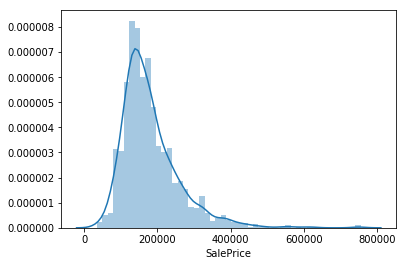

In [3]:
sns.distplot(traindf['SalePrice'])

It looks a little skewed to the right, but we should be able to transform this down the road to match. Let's describe the data.

In [4]:
traindf['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

So we notice that, for example, min isn't 0 or the like. It looks like a fairly well put together column. Let's check for nulls.

In [5]:
traindf['SalePrice'].isnull().sum()

0

Great! A full column with data that will be useful to us. One question that I have about this column is whether it's denoting prices over times in terms of nominal or real dollars. Let's pull `SalePrice` and `YrSold` to have a good look at whether the median price is increasing over time

In [6]:
traindf[['SalePrice', 'YrSold']].groupby('YrSold')['SalePrice'].median()

YrSold
2006    163995
2007    167000
2008    164000
2009    162000
2010    155000
Name: SalePrice, dtype: int64

Interesting! I thought we'd be working with a lot more years of data. Since five observations doesn't lend us a lot of statistical power, we really can't say if we're working with real or nominal dollar amounts. It shouldn't matter terribly if our data only covers four years, though.

One interesting thing is that you notice price housing dipping substantially after the housing bubble burst in 2008. That's expected, and that's what our data reflects, so I think we're good using this data as is. I briefly considered trying to create a variable from the data that reflects the housing bubble (such as a binary), but decided that this would likely create more noise in our analysis than I cared to introduce. Let's start investigating the other variables that this dataset offers us.

With the dependent variable out of the way, let's start looking at missing data for the entire dataframe.

## Missing Data

In [7]:
missing = traindf.isnull().sum().sort_values(ascending=False)
missing = missing.loc[missing != 0].to_frame('Missing Count')
missing['Percent'] = missing / len(traindf)
missing

,Missing Count,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Wow. There are certain values that just seem to be straight up missing from housing data. There's a big jump from `GarageCond` to `LotFrontage`, so I think that's where I'm going to draw a line. I'm going to drop these variables from the dataset since they're missing so many values. Then I'll consider what to do about the rest.

In [8]:
to_drop = missing[0:6].index.tolist()
traindf = traindf.drop(to_drop, axis=1)

Now, I know that there are other variable types for garage and basement. Let's look at all the values for each set, see if there is a feature variable that explains the columns with missing data well enough, and drop it if it does. Let's start with the garage variables.

In [9]:
traindf.filter(like='Garage').columns

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond'],
      dtype='object')

Okay. So the two garage features here that don't have any missing data are `GarageCars` and `GarageArea`. The real question now is whether I feel like these two can explain whatever meaning might be lost if I decide to drop one, some, or all of these variables.

However, I also notice that they all have the same exact number of missing values, so let's see if those are all the same entries or not (It's my hunch that they are).

In [10]:
garage = traindf.filter(like='Garage')
garage_masked = garage[(garage['GarageType'].isnull()) & (garage['GarageYrBlt'].isnull()) & (garage['GarageFinish'].isnull()) & (garage['GarageQual'].isnull()) & (garage['GarageCond'].isnull())]
garage_masked.shape

(81, 7)

In [11]:
print(garage_masked['GarageCars'].sum())
print(garage_masked['GarageArea'].sum())

0
0


Great! All the missing values correspond to all the same rows. Also, interestingly, all the values that are missing the 5 of 7 `Garage` variables also have zeros in for `GarageCars` and `GarageArea`. It's extremely probable that entries that don't have those 5 `Garage` values simply don't have garages.

I imagine that a house _without_ a garage is worth significantly less than a house _with_ a garage. What I'll do is create a mask for my dataframe that identifies what rows miss this data, and correspondingly create a dummy column that is 1 if a house does not have a garage.

In [12]:
def no_garage(df, inplace=False):
    copy = df
    mask = (copy['GarageType'].isnull()) & (copy['GarageYrBlt'].isnull()) & (copy['GarageFinish'].isnull()) & (copy['GarageQual'].isnull()) & (copy['GarageCond'].isnull())
    copy['No_Garage'] = 1
    copy['No_Garage'] = copy['No_Garage'].where(cond=mask, other=0)
    if inplace is False:
        return copy
    else:
        df = copy
        return

In [13]:
no_garage(traindf, inplace=True)

Awesome! Now we have transformed our training dataset to have a dummy for whether or not there is a garage. As long as I don't include those 5 garage variables as feature variables in my model, but _do_ include the new dummy variable I've created, I'll be golden.

Now let's see if we can find any commonality in the `Bsmt` terms.

In [14]:
bsmt = traindf[['BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'TotalBsmtSF']]
bsmt.loc[bsmt.isnull().any(axis=1)]

,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,TotalBsmtSF
17,NaN,NaN,NaN,NaN,NaN,0
39,NaN,NaN,NaN,NaN,NaN,0
90,NaN,NaN,NaN,NaN,NaN,0
102,NaN,NaN,NaN,NaN,NaN,0
156,NaN,NaN,NaN,NaN,NaN,0
182,NaN,NaN,NaN,NaN,NaN,0
259,NaN,NaN,NaN,NaN,NaN,0
332,No,NaN,GLQ,TA,Gd,3206
342,NaN,NaN,NaN,NaN,NaN,0
362,NaN,NaN,NaN,NaN,NaN,0


I can see that most of these rows are generated by houses that have no basement. There are two exceptions. Index locations 332 and 948.

At 342, we see that the basement has a value for `BsmtFinType1` but not `BsmtFinType2`. The documentation for the data says "Quality of second finished area (if present)". I feel safe assuming that this is the only instance where a basement does not have a second finished area. What I will do is just copy the first style into the second since it should, in theory, have the same effect in the buyers mind in price taking. 

At 948, we see that it simply has a NaN value for `BsmtExposure`. If this data wasn't filled out, I think I can safely assume that it is not exposed (or something to that effect). I'll fill in that data manually.

Let's create another dataframe transformation function that handles this case for my training dataset as well as my test dataset if it's the case that this type of missing data is repeated. If `TotalBsmtSF` is 0, I'll also have it break out a dummy column to indicate that it doesn't have a basement. I can use that in place of the variables that have missing values.

In [15]:
def basement_handling(df, inplace=False):
    copy = df
    cond1 = copy['TotalBsmtSF'] == 0
    copy['No_Bsmt'] = 1
    copy['No_Bsmt'] = copy['No_Bsmt'].where(cond=cond1, other=0)
    copy['BsmtFinType2'].fillna(value=copy['BsmtFinType1'], inplace=True)
    cond2 = (copy['TotalBsmtSF'] != 0) & (copy['BsmtExposure'] is not np.nan)
    copy['BsmtExposure'] = copy['BsmtExposure'].where(cond=cond2, other='No')
    if inplace is False:
        return copy
    else:
        df = copy
        return

Okay. Now to turn our gaze to `MasVnrArea` and `MasVnrType` to see what's missing there. I'm going to see if this is a case where `NaN` could be interpreted as a zero or not by looking to see if there are any houses in the dataset that have 0 for `MasVnrArea`.

In [16]:
vnrarea_0 = traindf[['MasVnrArea', 'MasVnrType']].loc[traindf['MasVnrArea'] == 0]
print(vnrarea_0.shape)
vnrarea_0.head()

(861, 2)


,MasVnrArea,MasVnrType
1,0.0,None
3,0.0,None
5,0.0,None
8,0.0,None
9,0.0,None


There are a lot of houses that have 0 `MasVnrArea`. And it looks like they correspondingly have a `Nonetype` object in the `MasVnrType` column. Let's see if this is the case for _all_ entries.

In [17]:
vnrarea_0['MasVnrType'].value_counts()

None       859
Stone        1
BrkFace      1
Name: MasVnrType, dtype: int64

I think it's an error in the data that something with zero area can have a style. I'll eventually rewrite these values as zero. Let's see if we can figure out where the `NaN`s come from in the `MasVnrType` column.

In [18]:
traindf[['MasVnrType', 'MasVnrArea']].loc[traindf['MasVnrType'].isnull()]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


Okay. I'm just going to fill these in with zeros for `MasVnrArea` and `None` for `MasVnrType`. If they had this feature, I'm assuming it'd be recorded. Because they're `NaN`, my best assumption is that there was any data to fill in these fields because it didn't exist. That might not _always_ be the case, but I think it's a good assumption, so I'm going to go with it. Let's write a function to handle it.

In [19]:
def masvnr_handling(df, inplace=False):
    copy = df
    copy['MasVnrArea'] = copy['MasVnrArea'].fillna(0)
    copy['MasVnrType'] = copy['MasVnrType'].where((copy['MasVnrArea'] != 0), other=np.nan)
    if inplace is False:
        return copy
    else:
        df = copy
        return

Okay. One last variable. `Electrical`. Let's look at the column generally to figure out what it contains, and then look at the missing space specifically.

In [20]:
traindf['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

This just may be an odd case of a house that doesn't have electricty. I'll leave it be. I do this because this data is categorical, and the `.get_dummies()` dataframe method won't break out a dummy variable for `np.nan` objects when ran.

Now that we've dealt with _how_ to handle missing data, let's actually apply the three functions to our training dataset.

In [21]:
no_garage(traindf, inplace=True)
basement_handling(traindf, inplace=True)
masvnr_handling(traindf, inplace=True)

traindf.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,No_Garage,No_Bsmt
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,2,2008,WD,Normal,208500,0,0
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,5,2007,WD,Normal,181500,0,0
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,9,2008,WD,Normal,223500,0,0
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,2,2006,WD,Abnorml,140000,0,0
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,12,2008,WD,Normal,250000,0,0


## Determining Feature Variables

Now that we've got missing data out of the way, we need to shift our gaze towards the variables we want to use in our model. Let's get the absolute value of each correlation between the variables and arrange them in order of magnitude so we can see what variables might best be related to `SalePrice`.

In [22]:
corr_magnitudes = traindf.corr().apply(lambda x: abs(x))['SalePrice'].sort_values(ascending=False)[1:]
corr_magnitudes

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
No_Garage        0.236832
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
No_Bsmt          0.152829
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

I'm obviously not interested in using all of the variables, especially the ones where the correlation is near zero. The ones I'm most interested in are at the top of the list. To start, let's say I arbitrarily want to have 10 feature variables in my model. I'll keep this data `corr_magnitudes` for later in case I want to add variables.

Looking, however at the list, I notice a couple of things. `GarageCars` and `GarageArea` practically tell me the same thing. I can drop one of them. My model is trying to predict selling prices set by humans, and prices are a cause of supply and demand. In making those negotions for selling price, I think a human is a lot more likely to set a price on how many cars a garage can hold rather than it's square footage. While `GarageArea` may afford me a variable with more depth and variability that could tighten confidence intervals in a multivariate analysis, I think `GarageCars` affords me more predictive power. So I'll keep that one.

Another thing that is subtle. `TotalBsmtSF` and `1stFlrSF` essentially tell the same story as well. I don't know about you, but my history with houses has been that the basement matches the first floor in terms of square footage. You don't usually have a basement that is bigger or smaller than the first floor. Let's check this hunch by looking at their correlation.

In [23]:
traindf.corr()['TotalBsmtSF'].loc['1stFlrSF']

0.8195299750050355

It's a bit farther away from one than I thought, so let's graph the two.

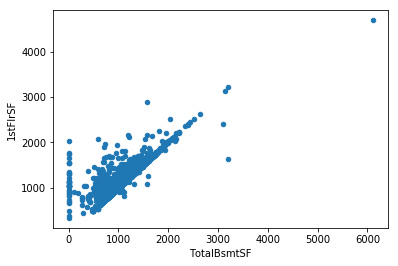

In [24]:
traindf.plot(x='TotalBsmtSF', y='1stFlrSF', kind='scatter')

Looking at this, I notice that my hunch seems to hold _in most, but not all cases_. You can see that linear line coming through the scatterplot. However, there is a number of homes that have first floors that have more square footage than the basement, and even fewer homes that have bigger basements than the first floor. I can calculate how many cases that is, so let's do it real quick before we make a final decision.

In [25]:
len(traindf[traindf['TotalBsmtSF'] != traindf['1stFlrSF']])

719

That's almost half the cases! Let's keep both.

Alright. I think I know what 10 feature variables I want to deal with first. Let's pull the names into a list I can call later, and start looking at the relationships of each of them.

In [26]:
features = corr_magnitudes.index[0:11].tolist()
features.remove('GarageArea')
features.insert(0, 'SalePrice')
features.remove('GarageYrBlt')
features.insert(10, 'No_Garage')
features

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'No_Garage']

## Feature Variable Normalization

I'm about to engage in some mathematical transformations of the feature variables that I've chosen. I'm going to keep a running function of the transformations I decide to use in the following function so I can apply it quickly to the test set later:

In [27]:
def var_transforms(df, inplace=False, saleprice=True):
    copy = df
    if saleprice is True:
        copy['log_SalePrice'] = np.log(copy['SalePrice'])
    copy['log_GrLivArea'] = np.log(copy['GrLivArea'])
    copy['sqrt_TotalBsmtSF'] = np.sqrt(copy['TotalBsmtSF'])
    copy['log_1stFlrSF'] = np.log(copy['1stFlrSF'])
    copy['log_TotRmsAbvGrd'] = np.log(copy['TotRmsAbvGrd'])
    copy = copy.join(pd.get_dummies(copy['OverallQual'], prefix='OverallQual', dummy_na=False))
    if inplace is False:
        return copy
    else:
        df = copy
        return

Let's look at SalesPrice and see if it meets the four categories of Hair et al. (2014): Normality, heteroskedasticity, linearity, and absence of correlated errors.

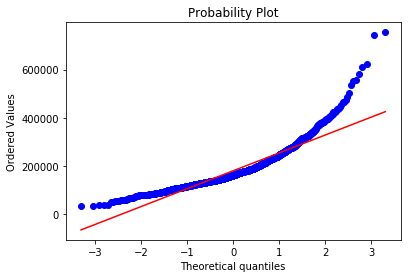

In [28]:
res = scipy.stats.probplot(traindf['SalePrice'], plot=plt)

The distribution demonstrates positive skewedness. Let's try a log transformation of `SalePrice`.

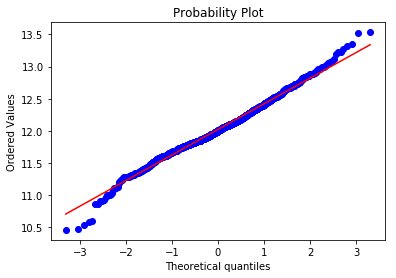

In [29]:
traindf['log_SalePrice'] = np.log(traindf['SalePrice'])

res = scipy.stats.probplot(traindf['log_SalePrice'], plot=plt)

I'm good with that! Let's move on to `OverallQual`.

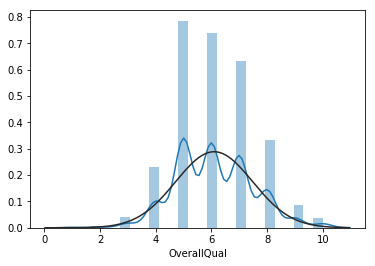

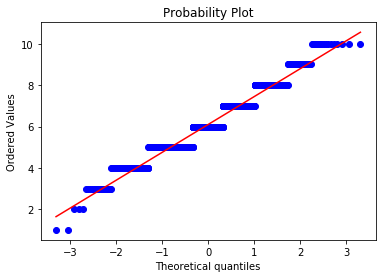

In [30]:
sns.distplot(traindf['OverallQual'], fit=scipy.stats.norm);
fig = plt.figure()
res = scipy.stats.probplot(traindf['OverallQual'], plot=plt)

With categorical data, I'm most worried about heteroskedasticity. It doesn't look like the case here. No transformation needed, and I'll be fine breaking that into dummies. Let's move on.

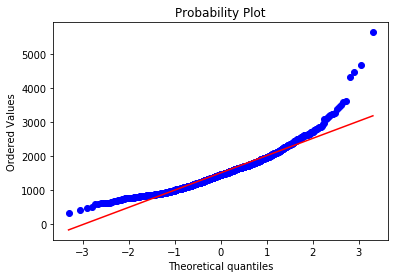

In [31]:
res = scipy.stats.probplot(traindf['GrLivArea'], plot=plt)

Seems like `GrLivArea` is a similar case to `SalePrice`. I'll apply a log transformation.

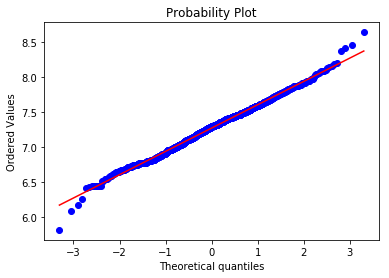

In [32]:
traindf['log_GrLivArea'] = np.log(traindf['GrLivArea'])

res = scipy.stats.probplot(traindf['log_GrLivArea'], plot=plt)

Looks good! Onto `GarageCars`.

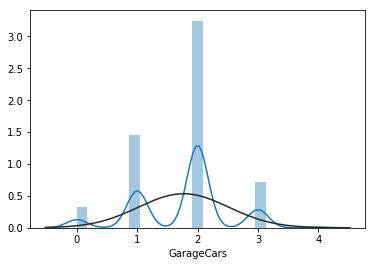

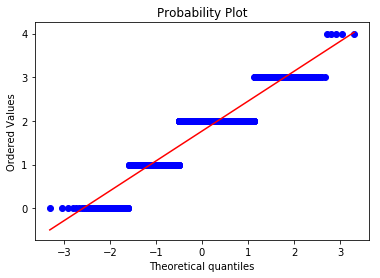

In [33]:
sns.distplot(traindf['GarageCars'], fit=scipy.stats.norm);
fig = plt.figure()
res = scipy.stats.probplot(traindf['GarageCars'], plot=plt)

Looks fine. Since it's already numerical, I don't need to do a transformation on it.

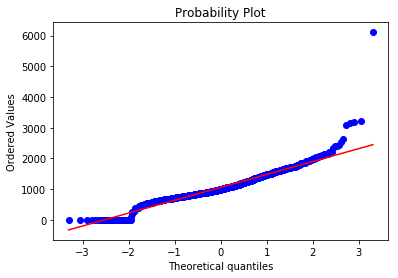

In [34]:
res = scipy.stats.probplot(traindf['TotalBsmtSF'], plot=plt)

There's a lot of zeros here, but it looks like I'll want to apply a log transformation generally. I can use numpy's `.log1p()` method to take care of zeros so they don't mess up the math.

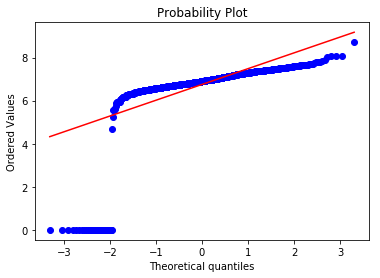

In [35]:
traindf['log1_TotalBsmtSF'] = np.log1p(traindf['TotalBsmtSF'])

res = scipy.stats.probplot(traindf['log1_TotalBsmtSF'], plot=plt)

Ehhhhh, I don't like that. Let's try a square root transformation.

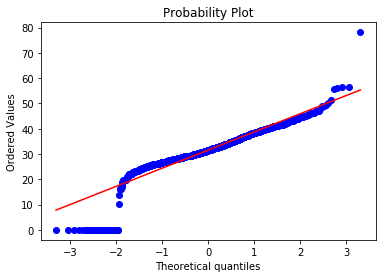

In [36]:
traindf['sqrt_TotalBsmtSF'] = np.sqrt(traindf['TotalBsmtSF'])

res = scipy.stats.probplot(traindf['sqrt_TotalBsmtSF'], plot=plt)

I like that a bit more than what I originally had! Let's continue to `1stFlrSF`.

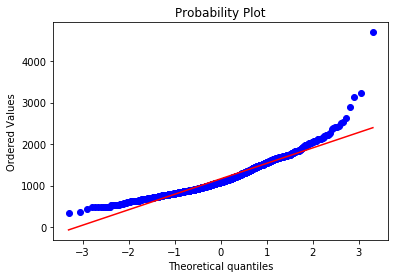

In [37]:
res = scipy.stats.probplot(traindf['1stFlrSF'], plot=plt)

Log transformation.

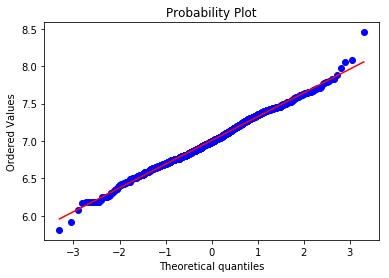

In [38]:
traindf['log_1stFlrSF'] = np.log(traindf['1stFlrSF'])

res = scipy.stats.probplot(traindf['log_1stFlrSF'], plot=plt)

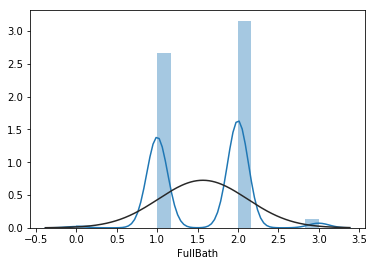

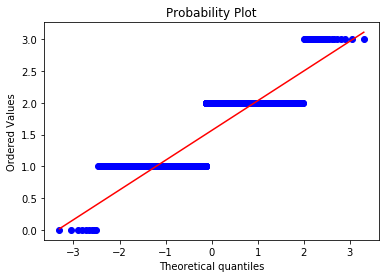

In [39]:
sns.distplot(traindf['FullBath'], fit=scipy.stats.norm);
fig = plt.figure()
res = scipy.stats.probplot(traindf['FullBath'], plot=plt)

I'm going to leave this one alone since the data barely varies.

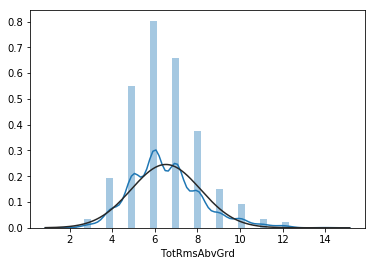

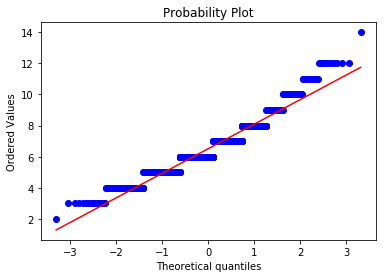

In [40]:
sns.distplot(traindf['TotRmsAbvGrd'], fit=scipy.stats.norm);
fig = plt.figure()
res = scipy.stats.probplot(traindf['TotRmsAbvGrd'], plot=plt)

Positive skewedness. Let's log it.

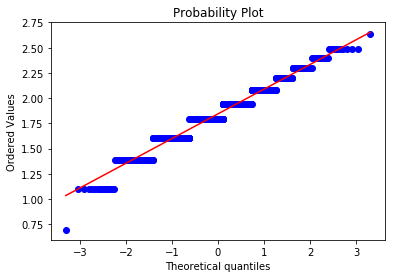

In [41]:
traindf['log_TotRmsAbvGrd'] = np.log(traindf['TotRmsAbvGrd'])

res = scipy.stats.probplot(traindf['log_TotRmsAbvGrd'], plot=plt)

Great!

I'm not going to modify any of the year data since, in theory, it's about evenly distributed and should stand for itself-- not some transformation. I don't think transformations won't do much to add to predictive power. So yeah, I'll leave it alone.

## Modeling

### 1) Linear Regression

Let's start with just a simple linear regression model to see what my root mean squared error would be.

In [42]:
train_transformed = var_transforms(traindf, inplace=False)

model_1 = train_transformed[['log_SalePrice', 'log_GrLivArea', 'GarageCars', 'sqrt_TotalBsmtSF', 'log_1stFlrSF', 'FullBath', 'log_TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'No_Garage']].join(train_transformed.filter(like='OverallQual_'))
model_1.head()

,log_SalePrice,log_GrLivArea,GarageCars,sqrt_TotalBsmtSF,log_1stFlrSF,FullBath,log_TotRmsAbvGrd,YearBuilt,YearRemodAdd,No_Garage,OverallQual_1,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallQual_10
0,12.247694,7.444249,2,29.257478,6.752270,2,2.079442,2003,2003,0,0,0,0,0,0,0,1,0,0,0
1,12.109011,7.140453,2,35.524639,7.140453,2,1.791759,1976,1976,0,0,0,0,0,0,1,0,0,0,0
2,12.317167,7.487734,2,30.331502,6.824374,2,1.791759,2001,2002,0,0,0,0,0,0,0,1,0,0,0
3,11.849398,7.448334,3,27.495454,6.867974,1,1.945910,1915,1970,0,0,0,0,0,0,0,1,0,0,0
4,12.429216,7.695303,3,33.837849,7.043160,2,2.197225,2000,2000,0,0,0,0,0,0,0,0,1,0,0


In [43]:
target_1 = model_1['log_SalePrice'].values
features_1 = model_1.drop('log_SalePrice', axis=1).values

linearmodel = linear_model.LinearRegression()
linearmodel.fit(features_1, target_1)
predictions = linearmodel.predict(features_1)
sklearn.metrics.mean_squared_error(target_1, predictions)

0.025273229064736048

Fairly good. Let's apply this to the test set, clean it up, and export it to Kaggle. I'll let you know what my score was when I submit this first one.

In [44]:
test_1 = no_garage(testdf, inplace=False)
test_1 = basement_handling(test_1, inplace=False)
test_1 = masvnr_handling(test_1, inplace=False)
test_1 = var_transforms(test_1, inplace=False, saleprice=False)

test_1_set = test_1[['log_GrLivArea', 'GarageCars', 'sqrt_TotalBsmtSF', 'log_1stFlrSF', 'FullBath', 'log_TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'No_Garage']].join(test_1.filter(like='OverallQual_'))

# test_pred = linearmodel.predict(test_1_set.values) ###THIS THROWS A ValueError DUE TO np.nan VALUES.###

I wasn't expecting to encounter `np.nan` values in my test set. I'm going to fill `np.nan` values with the mean of the column so as to not throw off the regression as much as I would if I filled it with a zero. My transformations should've taken care of the most troublesome `np.nan` values already.

In [45]:
test_1_set.fillna(test_1_set.mean(), inplace=True)

test_pred = linearmodel.predict(test_1_set.values)
test_pred = np.exp(test_pred)
to_kaggle = pd.DataFrame(data=test_pred, columns=['SalePrice']).join(test_1['Id'])
to_kaggle = to_kaggle[['Id', 'SalePrice']]
to_kaggle.to_csv('submission1.csv', index=False, header=True)

After submitting this model to Kaggle, my score was a __0.15710__. Pretty good for a first try! However, if this score is root mean squared error, it was probably a little bit of luck since my training set RMSE is significantly higher.

### 2) Linear Regression + Interaction Terms

I like this set of data that I got. Let's try controlling with _just_ interaction terms since I've already normalized the features how I like it. I'll use the `PolynomialFeatures` class from sklearn.

In [46]:
poly_obj = sklearn.preprocessing.PolynomialFeatures(degree=2, interaction_only=True)
features_2 = poly_obj.fit_transform(features_1)
linearmodel_2 = sklearn.linear_model.LinearRegression()
linearmodel_2.fit(features_2, target_1)
predictions = linearmodel_2.predict(features_2)
sklearn.metrics.mean_squared_error(target_1, predictions)

0.01881915896287942

Holy cow, that's a lot lower. Let's get a test set ready to go and submit it to Kaggle.

In [47]:
test_2 = no_garage(testdf, inplace=False)
test_2 = basement_handling(test_2, inplace=False)
test_2 = masvnr_handling(test_2, inplace=False)
test_2 = var_transforms(test_2, inplace=False, saleprice=False)

test_2_set = test_2[['log_GrLivArea', 'GarageCars', 'sqrt_TotalBsmtSF', 'log_1stFlrSF', 'FullBath', 'log_TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'No_Garage']].join(test_1.filter(like='OverallQual_'))

test_2_set.fillna(test_2_set.mean(), inplace=True)

test_2_set = poly_obj.fit_transform(test_2_set.values)

test_pred = linearmodel_2.predict(test_2_set)
test_pred = np.exp(test_pred)
to_kaggle = pd.DataFrame(data=test_pred, columns=['SalePrice']).join(test_1['Id'])
to_kaggle = to_kaggle[['Id', 'SalePrice']]
to_kaggle.to_csv('submission2.csv', index=False, header=True)

Danggit. It scored lower: __0.17279__. I was probably overfitting a bit with all the interaction terms.

### 3) Lasso Regression + Interaction Terms

I am interested in using the interaction terms where they're justified, however (Since some of the terms are interrelated), so maybe a Lasso regression might take terms to zero that don't matter so I don't overfit.

In [48]:
linearmodel_3 = sklearn.linear_model.Lasso(alpha=1)
linearmodel_3.fit(features_2, target_1)
predictions = linearmodel_3.predict(features_2)
sklearn.metrics.mean_squared_error(target_1, predictions)

0.025730782750291614

It's higher than before, but this is on a training set, so I'm okay with that. Let's prepare a submission.

In [49]:
test_pred = linearmodel_3.predict(test_2_set)
test_pred = np.exp(test_pred)
to_kaggle = pd.DataFrame(data=test_pred, columns=['SalePrice']).join(test_1['Id'])
to_kaggle = to_kaggle[['Id', 'SalePrice']]
to_kaggle.to_csv('submission3.csv', index=False, header=True)

That scored __0.16409__. Worst than my first attempt, but better than the last attempt. All my regressions are sitting fairly close to each other!

### 4) K Nearest Neighbors

I'm out of options here. Let's give K Nearest Neighbors a try without the interaction terms.

In [50]:
target_4 = traindf['SalePrice'].values

model_4 = sklearn.neighbors.KNeighborsClassifier()
gridsearch = sklearn.model_selection.GridSearchCV(model_4, {"n_neighbors": list(range(1,21)), "weights": ['uniform', 'distance'], 'p': [1, 2]}, scoring='f1_micro')
gridsearch.fit(features_1, target_4)
predictions = gridsearch.predict(features_1)
sklearn.metrics.mean_squared_error(target_4, predictions)

1332618050.939726

That's ridiculously high. I don't even think that's worth submitting. But heck. Let's do it. We got nothing to lose.

In [51]:
test_pred = gridsearch.predict(test_1_set)
to_kaggle = pd.DataFrame(data=test_pred, columns=['SalePrice']).join(test_1['Id'])
to_kaggle = to_kaggle[['Id', 'SalePrice']]
to_kaggle.to_csv('submission4.csv', index=False, header=True)

My kaggle score there was __0.27227__. My worst one.

## Conclusion

In the end, I recommend the first model that I produced, which is the bare-bones linear regression model with the terms normalized in the way I did. The reason why I suggest it is because I spent a lot of time fine-tuning the variables of the model so that they would fit well with the assumptions of linear regression, and I think they performed well. I tried adding a few transforms of the features that we already had, but that caused overfitting more than anything. So I would normalize any future data like I did, and simply run it through a standard linear regression. It was the best model in predicting out of sample out of all four I tried.